In [118]:
import pandas as pd
import numpy as np

RANDOM_STATE = 42

In [119]:
df = pd.read_csv('data/HAD.csv')
df.head()

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING,MRS_90,MRS_90_DICHO
0,70,0,0,3,0,-1,1,0,0,0,...,64,0,96,0,180,0,-1,1,0,0
1,55,0,0,6,0,142,0,3,0,0,...,38,0,104,0,165,0,-1,1,4,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,2,0
3,81,0,0,10,0,-1,1,0,0,0,...,69,0,90,0,115,0,-1,1,3,1
4,81,0,1,11,0,-1,1,0,0,0,...,98,0,110,0,120,0,-1,1,0,0


In [120]:
target_feature = 'MRS_90'
y = df.filter([target_feature])
# y.to_csv('data/HAD_target.csv', index=False)

#### Because of the warning given while imputing missing values, 'SERUM_GLUCOSE' and 'VALV_HEART' columns are removed due to not having any other entry than '-1' value

In [121]:
df = df.drop(columns={'SERUM_GLUCOSE', 'SERUM_GLUCOSE_MISSING', 'VALV_HEART', 'MRS_90', 'MRS_90_DICHO'}, axis=1)
df

,AGE,AGE_MISSING,SEX_F,NIHSS_BL,NIHSS_BL_MISSING,SYS_BLOOD_PRESSURE,SYS_BLOOD_PRESSURE_MISSING,PREV_MRS,PREV_MRS_MISSING,ORAL_ANTICOAGULANT,...,CTA_CS,CTA_CS_MISSING,ONSET_TO_ADMISSION,ONSET_TO_ADMISSION_MISSING,ONSET_TO_IMAGING,ONSET_TO_IMAGING_MISSING,ONSET_TO_TPA,ONSET_TO_TPA_MISSING,ONSET_TO_GROIN,ONSET_TO_GROIN_MISSING
0,70,0,0,3,0,-1,1,0,0,0,...,-1,1,64,0,96,0,180,0,-1,1
1,55,0,0,6,0,142,0,3,0,0,...,-1,1,38,0,104,0,165,0,-1,1
2,73,0,0,3,0,170,0,0,0,1,...,-1,1,-1,1,-1,1,-1,1,-1,1
3,81,0,0,10,0,-1,1,0,0,0,...,-1,1,69,0,90,0,115,0,-1,1
4,81,0,1,11,0,-1,1,0,0,0,...,-1,1,98,0,110,0,120,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,71,0,0,3,0,-1,1,0,0,0,...,-1,1,179,0,193,0,229,0,-1,1
940,63,0,0,3,0,142,0,3,0,0,...,-1,1,-1,1,142,0,165,0,-1,1
941,61,0,1,0,0,104,0,0,0,0,...,-1,1,-1,1,-1,1,-1,1,-1,1
942,80,0,1,12,0,-1,1,0,0,0,...,1,0,480,0,520,0,-1,1,630,0


## Generating missing data based on sklearn imputers

In [122]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer_df = df.copy()  # Creating a copy of the original DataFrame for imputation

# Initialize IterativeImputer with median strategy for missing values
imp = IterativeImputer(missing_values=-1, initial_strategy='median', random_state=RANDOM_STATE)

# Iterate through columns in the DataFrame
for col in imputer_df.columns:
    # Skip columns ending with '_MISSING'
    if col.endswith('_MISSING'):
        continue
    # Check if there is a corresponding missing flag column
    elif col + "_MISSING" in df.columns:
        # Check if there are missing values to impute
        if (imputer_df[col + "_MISSING"] == 1).any() and (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()
    else:
        # Check if there are missing values to impute
        if (imputer_df[col] == -1).any():
            # Fit imputer on the column and transform the values
            imp.fit(imputer_df[[col]])
            imputer_df[col] = imp.transform(imputer_df[[col]]).ravel()

# Remove columns related to missingness flags
imputer_df = imputer_df[imputer_df.columns.drop(list(imputer_df.filter(regex='MISSING')))]

# Save the imputed DataFrame to a CSV file
# imputer_df.to_csv('data/HAD_after_imputer.csv', index=False)

imputer_df.head()


,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70.0,0,3.0,148.0,0.0,0.0,1.0,1.0,0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,64.0,96.0,180.0,217.0
1,55.0,0,6.0,142.0,3.0,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,38.0,104.0,165.0,217.0
2,73.0,0,3.0,170.0,0.0,1.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,90.0,116.0,170.0,217.0
3,81.0,0,10.0,148.0,0.0,0.0,1.0,0.0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,69.0,90.0,115.0,217.0
4,81.0,1,11.0,148.0,0.0,0.0,1.0,1.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,98.0,110.0,120.0,217.0


### Using BIC to get the optimal number of components for GMM

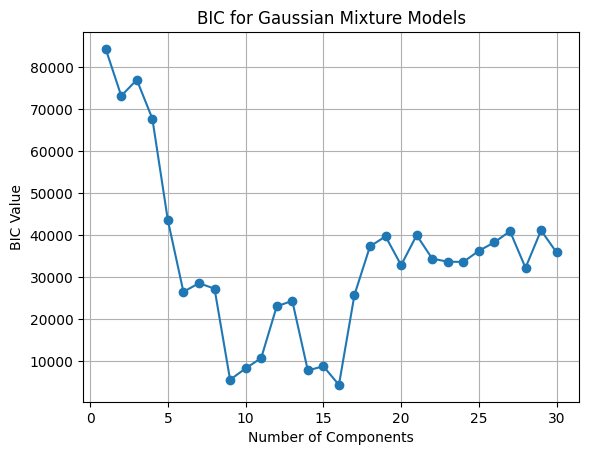

In [123]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def compute_bic(X, n_components_range):
    """
    Computes the Bayesian Information Criterion (BIC) for Gaussian Mixture Models with different numbers of components.
    
    Parameters:
        X (array-like): Input data.
        n_components_range (range): Range of number of components to evaluate.
        
    Returns:
        list: BIC values for each number of components.
    """
    bic = []  # List to store BIC values
    for n_components in n_components_range:
        # Create Gaussian Mixture Model with specified number of components
        gmm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
        gmm.fit(X)  # Fit the model to the data
        bic.append(gmm.bic(X))  # Calculate BIC and add to list
    return bic  # Return list of BIC values

n_components_range = range(1, 31)  # Range of number of components to evaluate

bic_values = compute_bic(imputer_df, n_components_range)  # Compute BIC values

optimal_n_components = n_components_range[np.argmin(bic_values)]  # Determine optimal number of components

# Plotting BIC values
plt.plot(n_components_range, bic_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Value')
plt.title('BIC for Gaussian Mixture Models')
plt.grid(True)
plt.show()


### Gaussian Mixture Model fitting

In [124]:
# Create Gaussian Mixture Model with optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=RANDOM_STATE)

# Fit the Gaussian Mixture Model to the imputed DataFrame
gmm.fit(imputer_df)

GaussianMixture(n_components=16, random_state=42)

### Can set all the values of a specific feature to -1 for the purpose of displaying it's distribution on the heatmap below

In [125]:
# Saving the values of a feature to mark them in the heatmap, e.g. CTA_CS
heatmap_feature = 'CTA_CS'
heatmap_feature_original_values = pd.Series(df[heatmap_feature].copy().values, index=df.index)

# Get maximum and minimum values from the column
heatmap_feature_max_value = df[heatmap_feature].max()
heatmap_feature_min_value = df[heatmap_feature].min()

df[heatmap_feature] = -1
# Check if the column exists
if heatmap_feature + '_MISSING' in df.columns:
    df[heatmap_feature + '_MISSING'] = 1

### Generating samples of missing values using conditional GMM

In [126]:
from ConditionalGMM.condGMM import CondGMM
import json

def gmm_generate_samples(n_datapoints=2, n_samples=1000, plot_histograms=False, print_index=False):
    """
    Generate samples using Conditional Gaussian Mixture Model for imputing missing data.

    Args:
        n_datapoints (int/str): Number of data points to consider
        n_samples (int): Number of samples to generate
        plot_histograms (bool): Whether to plot histograms of sampled data
        print_index (bool): Whether to print the index of the current data point
    Returns:
        pd.DataFrame: DataFrame with imputed missing data
    """
    if n_datapoints > df.shape[0]:
        n_datapoints = df.shape[0]

    # Create a copy of the DataFrame for data manipulation
    temp_df = df.head(n_datapoints).copy().astype(object)
    # Remove missing flag columns
    temp_df = temp_df[temp_df.columns.drop(list(temp_df.filter(regex='MISSING')))]
        
    for index, row in df.head(n_datapoints).iterrows():
        # Get indices and values of unknown and known features
        unknown_features_indexes, known_features_indexes, known_features_values = get_feature_indices_and_values(temp_df, index, row)
        
        # If all features are known, continue
        if len(unknown_features_indexes) == 0:
            continue
        
        # Initialize CondGMM
        cGMM = CondGMM(gmm.weights_, gmm.means_, gmm.covariances_, known_features_indexes)
        
        # Generate samples using Conditional GMM
        sampled_data = cGMM.rvs(known_features_values, size=n_samples, random_state=RANDOM_STATE)
        
        # Update unknown features with sampled data
        for feature_index in range(len(unknown_features_indexes)):
            temp_df.iloc[index, unknown_features_indexes[feature_index]] = json.dumps([sampled_data[sample_index][feature_index] for sample_index in range(n_samples)])

        # Plot histograms if specified
        if plot_histograms:
            plot_histogram(temp_df, unknown_features_indexes, index, sampled_data)
        
        # Print index if specified, for debugging purposes
        if print_index:
            print(index)
        
    return temp_df
        
def get_feature_indices_and_values(temp_df, index, row):    
    unknown_features_indexes = []  # Initialize list to store indices of unknown features
    
    # Iterate through columns in the DataFrame
    for col in df.columns:
        # Skip columns ending with '_MISSING'
        if col.endswith('_MISSING'):
            continue
        # Check if there is a corresponding missing flag column
        elif col + "_MISSING" in df.columns:
            # Identify unknown features where missing flag is 1 and value is -1
            if row[col + "_MISSING"] == 1 and row[col] == -1:
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        else:
            # Identify unknown features where value is -1
            if row[col] == -1:
                unknown_features_indexes.append(temp_df.columns.get_loc(col))  # Add index of feature
        
    # Find indices of known features
    known_features_indexes = list(set(range(temp_df.shape[1])) - set(unknown_features_indexes))
    
    # Extract values of known features for the given row
    known_features_values = temp_df.iloc[index, known_features_indexes]
    
    return unknown_features_indexes, known_features_indexes, known_features_values  # Return indices and values

def plot_histogram(temp_df, unknown_features_indexes, index, sampled_data, n_bins=20):
    # Create subplots based on the number of unknown features
    fig, axs = plt.subplots(sampled_data.shape[1], 1, figsize=(8, len(unknown_features_indexes) * 4))

    # Plot histograms for each feature
    plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins)

    # Add title and labels to the figure
    fig.suptitle(f'Histograms for index {index}', fontsize=20)  # Title with the index
    fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)  # X-axis label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)  # Y-axis label
    plt.show()  # Show the figure

    
def plot_features(temp_df, sampled_data, axs, unknown_features_indexes, index, n_bins):
    # Ensure axs is a list for consistency in cases when only one feature is plotted
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    for i in range(sampled_data.shape[1]):
        expected_value = imputer_df.iloc[index, unknown_features_indexes[i]]
        
        # Plot histogram for the feature
        axs[i].hist(sampled_data[:, i], bins=n_bins, alpha=0.5, label='sampled data')
        axs[i].hist(imputer_df[imputer_df.columns[unknown_features_indexes[i]]], bins=n_bins, alpha=0.2, label='marginal data')
        axs[i].set_title(f'{temp_df.columns[unknown_features_indexes[i]]}')
        
        # Add expected value as text on the histogram
        axs[i].text(0.95, 0.95, f'Expected value: {expected_value}', ha='right', va='top', transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
        
        axs[i].legend(loc='upper left')

In [127]:
%load_ext autoreload
%autoreload 2

n_datapoints = df.shape[0]
cgmm_df = gmm_generate_samples(n_datapoints=n_datapoints, n_samples=1000)
cgmm_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,AGE,SEX_F,NIHSS_BL,SYS_BLOOD_PRESSURE,PREV_MRS,ORAL_ANTICOAGULANT,HYPERTENSION,HYPERCHOL,ISCH_HEART,SMOKING,...,OCCLUSION_M2,OCCLUSION_ICA,OCCLUSION_ACA,OCCLUSION_PCA,OCCLUSION_VB,CTA_CS,ONSET_TO_ADMISSION,ONSET_TO_IMAGING,ONSET_TO_TPA,ONSET_TO_GROIN
0,70,0,3,"[149.3084947447068, 143.6969954680875, 140.801...",0,0,1,1,0,1,...,1,0,0,0,0,"[1.0003801978510058, 1.0010807807255546, 0.999...",64,96,180,"[216.99866465564128, 217.00055979044794, 217.0..."
1,55,0,6,142,3,0,1,1,0,0,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38,104,165,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,73,0,3,170,0,1,1,1,0,0,...,"[-0.0013353443587101014, -0.001276748575820309...","[0.0003801978510059632, -0.0010810565404082624...","[0.0006105857452838231, 0.0010531528533329036,...","[0.0005597904479310398, -3.955515385665504e-05...","[0.0010807807255546217, 0.0006815006973726244,...","[1.0008339221545488, 1.0000283183761305, 0.999...","[90.00045918007923, 90.0000297561395, 89.99956...","[115.99992983428854, 116.00093828380598, 116.0...","[169.99833903906648, 169.99948395527178, 170.0...","[217.00042961821913, 217.00009612077693, 217.0..."
3,81,0,10,"[156.029302781928, 151.06692921635403, 159.250...",0,0,1,0,1,0,...,0,0,0,1,0,"[1.0006105857452836, 1.0004591800792284, 1.000...",69,90,115,"[217.000380197851, 217.00083392215456, 217.000..."
4,81,1,11,"[155.2470568065575, 179.23502887822826, 157.19...",0,0,1,1,0,0,...,"[-0.06660293767301387, -0.07581068576232389, 0...","[-0.06109245457131153, 0.12073669045698227, 0....","[0.0008339221545489041, 0.0010531528533329036,...","[0.07781707409868324, -0.006397867619567066, -...","[0.0004591800792284367, -3.955515385665504e-05...","[0.9999298342885412, 1.0006815006973726, 1.000...",98,110,120,"[217.00108078072554, 216.99891894345959, 216.9..."


## Generating heatmap which helps visualize how cGMM distributes data

In [128]:
# Save the original values of the heatmap feature
heatmap_feature_values = cgmm_df[heatmap_feature]
heatmap_feature_values

0      [1.0003801978510058, 1.0010807807255546, 0.999...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [1.0008339221545488, 1.0000283183761305, 0.999...
3      [1.0006105857452836, 1.0004591800792284, 1.000...
4      [0.9999298342885412, 1.0006815006973726, 1.000...
                             ...                        
939    [1.0003801978510063, 1.0010807807255548, 0.999...
940    [0.9996198021489939, 0.9989192192744453, 1.000...
941    [1.0008339221545488, 1.0000283183761305, 0.999...
942    [1.001466679150754, 0.9990830418480526, 0.9991...
943    [1.0003801978510058, 1.0010807807255546, 0.999...
Name: CTA_CS, Length: 944, dtype: object

In [129]:
for i, entry in enumerate(heatmap_feature_values):
    if isinstance(entry, str):
        # Deserialize the string back into an array
        float_array = json.loads(entry)
        # Replace the string entry with the deserialized array
        heatmap_feature_values[i] = float_array

### Define the histogram bins for the heatmap

In [130]:
# Define bin edges and adjust number of bins
n_bins = 13
h_min = heatmap_feature_min_value
h_max = heatmap_feature_max_value
width = (h_max - h_min) / (n_bins-1)
bin_edges = np.arange(h_min - width/2, h_max +  width, width)

In [131]:
# Determine the number of samples based on the length of an entry with a list of values
list_length = None
for entry in heatmap_feature_values:
    if isinstance(entry, list):
        list_length = len(entry)
        break

histograms = []

for entry in heatmap_feature_values:
    if isinstance(entry, list):
        # Apply np.histogram with specified bin edges
        hist, _ = np.histogram(entry, bins=bin_edges)
        histograms.append(hist)
    else:
        # Single-value entry: Place it in the correct bin and set frequency to list_length
        hist = np.zeros(len(bin_edges) - 1)
        index = np.digitize([entry], bin_edges)[0] - 1
        if 0 <= index < len(hist):
            hist[index] = list_length
        histograms.append(hist)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


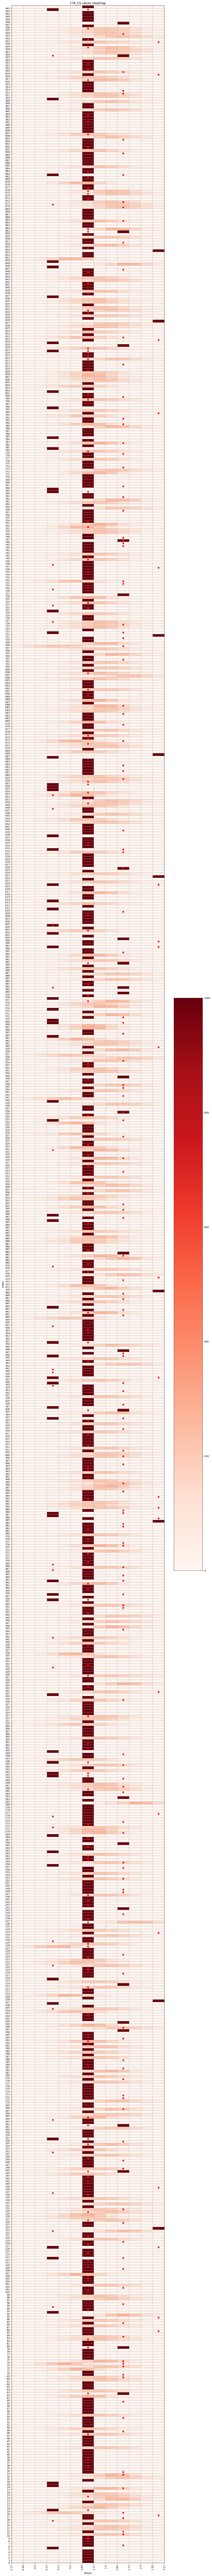

In [132]:
# Reshape histograms to fit imshow format (histograms should be a 2D array)
histograms_2d = np.array(histograms)

# Determine figure height based on the number of datapoints
fig_height = max(6, n_datapoints * 0.2)
fig_width = min(max(10, bin_edges.shape[0] * 1), 32)

extent = [bin_edges[0], bin_edges[-1], 0, len(histograms)]

# Create heatmap
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(histograms_2d, aspect='auto', cmap='Reds', extent=extent)
plt.colorbar()
plt.xticks(bin_edges, labels=np.round(bin_edges, 2), rotation=90)
plt.yticks(range(n_datapoints), range(n_datapoints))
plt.xlabel('Values')
plt.ylabel('Index')
plt.title(heatmap_feature + ' values Heatmap')

# Add markers for original values of a missing feature
original_values = heatmap_feature_original_values[heatmap_feature_original_values != -1]  # Selecting only the non -1 values
indexes = heatmap_feature_original_values.index[heatmap_feature_original_values != -1] + 0.5  # Indexes corresponding to non -1 values
plt.scatter(original_values, indexes, color='red', marker='o')

plt.grid(True)
plt.legend()
plt.savefig('images/heatmaps/' + heatmap_feature + '_heatmap.png')
plt.show()